## Intro

President Trump is well known for using Twitter. It is interesting to look inside and see whether there are some correlation between his tweets and the current public health crisis.   
In this project, Trump's tweets data, Covid cases and deaths data in US are analyzed and visualized.

In [35]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob 
import re
from wordcloud import WordCloud,STOPWORDS
from ipywidgets import widgets, interact, interactive, fixed
from collections import Counter 

## Read data for Trump's tweets

Tweet data of Trump is from Jan 1 2020 to Oct 1 2020, right before he hits COVID-19. Data source: http://www.trumptwitterarchive.com/archive, I find this website so interesting and amazing. I didn't scrape from twitter because sometimes Trumps delete some of his tweets, and this source archives those deleted tweets. Another reason is it takes time to get approval of Twitter developer account.

In [95]:
trump_tweet=pd.read_json('trump_tweet.json')

Total number of tweets from Trump during this period.

In [96]:
trump_tweet.shape

(9249, 7)

9249 tweets within 9 months! And whatelse do we have in meta data?

In [97]:
trump_tweet.columns

Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'id_str'],
      dtype='object')

In [98]:
#setup date time
trump_tweet['created_at']=pd.to_datetime(trump_tweet['created_at'])
#clean tweet text: remove url link and @
def clean_test(text):
    text=text.encode('ascii', 'ignore').decode('ascii')#remove emoji
    text=text.replace('&amp;',"and")
    return re.sub('(\w+:\/\/\S+)|(@\S+)','',text).strip().replace('\n',' ')#remove links

trump_tweet.text=trump_tweet.text.map(clean_test)   

Sentiment analysis with Textblob.

In [100]:
trump_tweet['polarity']=trump_tweet.text.map(lambda tweet:TextBlob(tweet).sentiment[0])
trump_tweet['subjectivity']=trump_tweet.text.map(lambda tweet:TextBlob(tweet).sentiment[1])
trump_tweet['length']=trump_tweet.text.map(lambda tweet:len(tweet.split()))
trump_tweet['month']=trump_tweet['created_at'].dt.month

In [102]:
trump_tweet.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,polarity,subjectivity,length,month
0,Twitter for iPhone,Thank you,2020-10-01 03:45:25+00:00,19616,65721,False,1311512518800470016,0.000000,0.000000,2,10
1,Twitter for iPhone,RT Big news! A Maine court sided with the RN...,2020-10-01 03:25:31+00:00,29393,0,True,1311507509958471680,0.000000,0.100000,21,10
2,Twitter for iPhone,Thank you Paul!,2020-10-01 03:00:33+00:00,15992,63294,False,1311501225423073280,0.000000,0.000000,3,10
3,Twitter for iPhone,"100,000 DEFECTIVE BALLOTS IN NEW YORK. THEY WA...",2020-10-01 02:59:02+00:00,51445,190750,False,1311500843309387776,0.224432,0.393939,38,10
4,Twitter for iPhone,"In just 3 and a half years, we have secured Am...",2020-10-01 02:51:05+00:00,18885,70838,False,1311498845860196352,0.019048,0.323810,41,10


We can remove extremely short tweets 

In [105]:
trump_tweet=trump_tweet[trump_tweet['length']>=3]

How many tweets left?

In [106]:
trump_tweet.shape

(8261, 11)

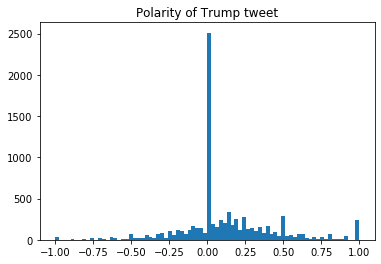

In [107]:
plt.hist(trump_tweet.polarity,bins='auto');
plt.title('Polarity of Trump tweet');

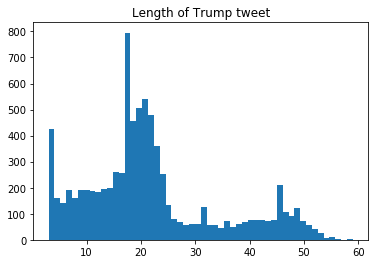

In [108]:
plt.hist(trump_tweet.length,bins='auto');
plt.title('Length of Trump tweet');

In [109]:
stopwords = set(STOPWORDS)
stopwords.update(["RT",'I','The','They','He','She','This','That','.','We','It','A'])
slider=widgets.IntSlider(min=1,max=10,step=1,description='Month',value=1)
def word_cloud_month(month):
    wc=WordCloud(background_color="white",stopwords=stopwords,width=800, 
                 height=500).generate(' '.join(trump_tweet[trump_tweet.month==month].text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off');

### Trump's favourite words
**Interactive** word cloud from Trump tweet by month. Manipulate by moving the slider.

In [110]:
interact(word_cloud_month,month=slider);# may need to wait for few moments after moving the slider

interactive(children=(IntSlider(value=1, description='Month', max=10, min=1), Output()), _dom_classes=('widget…

In [171]:
def words_favourite_month(month,n=5):
    ls=' '.join(trump_tweet[trump_tweet.month==month].text).split()
    counter=Counter(ls)
    for sw in stopwords:
        del counter[sw]
    result= counter.most_common(n)
    result=pd.DataFrame(result,columns=['Word','Frequency'])
    result.Frequency=result.Frequency/sum(trump_tweet.month==month)
    return result

def covid_freq_month(month):
    return len(re.findall('covid',' '.join(trump_tweet[trump_tweet.month==month].text),flags=re.IGNORECASE))/sum(trump_tweet.month==month)

Besides word cloud, we can also see Trump's favourite words every month in this way

In [177]:
#Favourite word in Jan
words_favourite_month(1)

,Word,Frequency
0,President,0.122286
1,Democrats,0.121143
2,will,0.112000
3,House,0.082286
4,Trump,0.061714


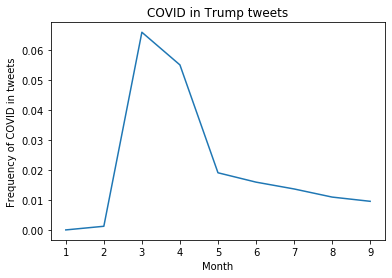

In [193]:
plt.plot(range(1,10),[covid_freq_month(i) for i in range(1,10)])
plt.title('COVID in Trump tweets')
plt.xlabel('Month')
plt.ylabel('Frequency of COVID in tweets');

## Read data of COVID data in US
The Covid data comes from https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20-%20County%20-%20Daily.csv, containing the daily count and rate per 100,000 people of confirmed COVID-19 cases, deaths or tests performed. The original source is New York Times and The COVID Tracking Project (https://covidtracking.com/).

In [195]:
covid_data=pd.read_csv('EconomicTracker-main/data/COVID - County - Daily.csv')

C:\Users\sugar\Anaconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [197]:
covid_data.head()

,year,month,day,countyfips,case_count,new_case_count,death_count,new_death_count,case_rate,death_rate,new_case_rate,new_death_rate
0,2020,1,21,1001,0,0,0,0,0,0,.,.
1,2020,1,21,1003,0,0,0,0,0,0,.,.
2,2020,1,21,1005,0,0,0,0,0,0,.,.
3,2020,1,21,1007,0,0,0,0,0,0,.,.
4,2020,1,21,1009,0,0,0,0,0,0,.,.


In [209]:
#Setup date time
covid_data['date']=covid_data.year.astype(str)+covid_data.month.astype(str).str.zfill(2)+covid_data.day.astype(str).str.zfill(2)
covid_data['date']=pd.to_datetime(covid_data['date'])

In [213]:
covid_data.columns

Index(['year', 'month', 'day', 'countyfips', 'case_count', 'new_case_count',
       'death_count', 'new_death_count', 'case_rate', 'death_rate',
       'new_case_rate', 'new_death_rate', 'date'],
      dtype='object')

In [243]:
#keep case rate, death rate, new case rate and new death rate
covid_rate=covid_data.iloc[:,8:]
#throwaway missing values


In [244]:
for i in range(4):
    subs=covid_rate.iloc[:,i]=='.'
    covid_rate.loc[subs,covid_rate.columns[i]]=np.nan
    covid_rate.iloc[:,i]=covid_rate.iloc[:,i].astype(float)
covid_rate=covid_rate.dropna()

In [245]:
covid_rate.describe()

,case_rate,death_rate,new_case_rate,new_death_rate
count,800995.000000,800995.000000,800995.000000,800995.000000
mean,574.680391,14.953762,7.807449,0.173114
std,979.795760,33.390671,14.444908,0.608187
min,0.000000,-36.700000,-253.000000,-6.330000
25%,0.000000,0.000000,0.000000,0.000000
50%,131.000000,0.000000,2.140000,0.000000
75%,722.000000,13.900000,9.720000,0.000000
max,7972.000000,349.000000,155.000000,12.400000


In [259]:
covid_rate.groupby('date').mean()

,case_rate,death_rate,new_case_rate,new_death_rate
date,,,,
2020-01-27,0.000065,0.000000,0.000009,0.000006
2020-01-28,0.000065,0.000000,0.000004,0.000000
2020-01-29,0.000065,0.000000,0.000004,0.000000
2020-01-30,0.000072,0.000000,0.000005,0.000000
2020-01-31,0.000088,0.000000,0.000006,0.000000
...,...,...,...,...
2020-10-03,1994.204010,44.068590,19.465477,0.349067
2020-10-04,2008.877626,44.229749,19.533886,0.351879
2020-10-05,2026.479663,44.434208,19.747876,0.354351


In [252]:
#average by data, aggregating all available counties
covid_rate_mean=covid_rate.groupby('date').mean()

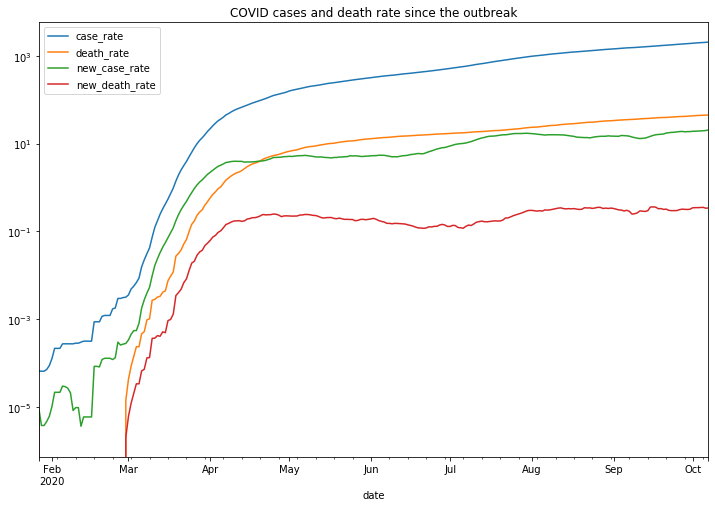

In [271]:
covid_rate_mean.plot(figsize=(12,8))
plt.yscale('log')
plt.title('COVID cases and death rate since the outbreak');

## Covid and Trump's tweet sentiment

In [ ]:
trump_sentiment=trump_tweet.groupby('month').mean()
trump_sentiment.index=pd.date_range(start='1/1/2020', end='10/1/2020',periods=10)
trump_sentiment['COVID Freq']=[covid_freq_month(i) for i in range(1,11)]

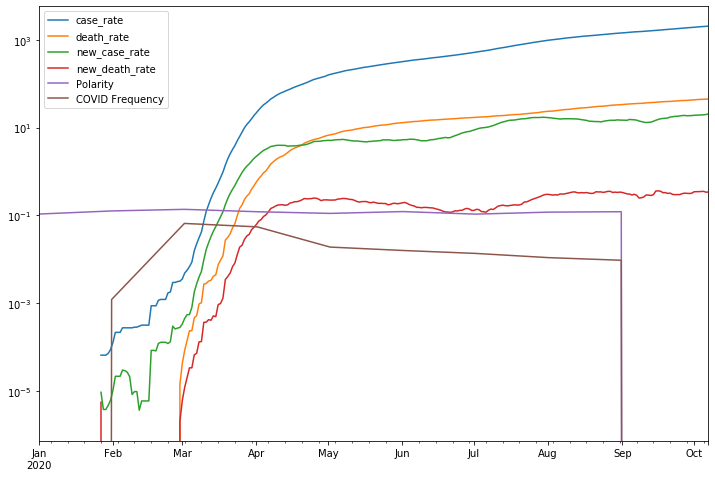

In [322]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
covid_rate_mean.plot(ax=ax)

trump_sentiment['polarity'].plot(ax=ax,label='Polarity')
trump_sentiment['COVID Freq'].plot(ax=ax,label='COVID Frequency')
ax.set_yscale('log')
plt.legend();
#df2['Col2'].plot(ax=ax)